# Machine Learning

In this file, we can find all instructions how to approach Machine Learning challenge and how to submit results in the correct form. 

We are going to work on three different types of Machine Learning problem:

- **Regression Problem**: The goal is to predict delay of flights.
- **Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **Binary Classification**: The goal is to predict if the flight will be cancelled.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
#import datasets
delayed_df = pd.read_pickle('delay_df.pkl')
cancel_df = pd.read_pickle('cancel_df.pkl')

In [3]:
# create smaller datasets to test with
delayed = delayed_df.sample(n=100000, random_state=0)
cancel = cancel_df.sample(n=100000,random_state=0)

### Regression

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of (1 day in advance) --> We can use average delay from previous x days but not the one from the actual flight we predict. 

## Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

In [34]:
# create smaller datasets to test with
delayed = delayed_df.sample(n=100000, random_state=0)

y = delayed['delay_code']
X = delayed.drop(['delay_code','dep_delay','arr_delay','dep_delay_bin','arr_delay_bin','fl_date'],axis=1)

# Standarize features because it would otherwise run over max iterations
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X_std,y,test_size=0.25,random_state=0)
                  
#instantiate logistic model
MNLR = LogisticRegression(C=1,max_iter=5000,random_state=0, multi_class='multinomial')
                  
# fit training data
MNLR.fit(X_train,y_train)

# predict with test data
y_pred_MNLR = MNLR.predict(X_test)

#create confusion matrix
cnf_matrix_MNLR = metrics.confusion_matrix(y_test, y_pred_MNLR)
print(cnf_matrix_MNLR)

print("Accuracy:", accuracy_score(y_test, y_pred_MNLR))
#print("Recall:", recall_score(y_test, y_pred_MNLR))
#print("Precision:", precision_score(y_test, y_pred_MNLR))

[[19657   332     6   146     0     7]
 [ 1430   623    10   193     0    12]
 [  122   110    12    61     0     1]
 [  949   238    13   380     0     5]
 [    5     1     0     1     0     0]
 [  444   207     1    18     0    16]]
Accuracy: 0.82752


<AxesSubplot:>

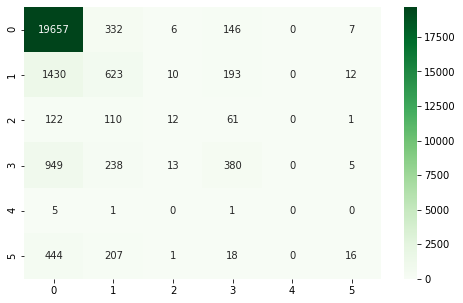

In [61]:
plt.figure(figsize=(8,5))
sns.heatmap(cnf_matrix_MNLR, annot=True, cmap='Greens',fmt='g')

In [5]:
# use gridsearchCV to try to get best parameters

parameter_grid = {
        'C': [1,2,3,4,5]
    }

MNLR = LogisticRegression(max_iter=5000,random_state=0,multi_class='multinomial')
gs = GridSearchCV(MNLR, parameter_grid, cv=5)
gs.fit(X_train, y_train)

gs.best_params_

{'C': 1}

In [75]:
# Completing the multinomial classification with SMOTE to help balance the dataset

delayed = delayed_df.sample(n=100000, random_state=0)

y = delayed['delay_code']
X = delayed.drop(['delay_code','dep_delay','arr_delay','dep_delay_bin','arr_delay_bin','fl_date'],axis=1)

# Standarize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X_std,y,test_size=0.25,random_state=0)

sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#instantiate logistic model
MNLR = LogisticRegression(C=1,max_iter=3000,random_state=0, multi_class='multinomial')
                  
# fit training data
MNLR.fit(X_train_res,y_train_res.ravel())

# predict with test data
y_pred_sm_MNLR = MNLR.predict(X_test)

cnf_matrix_sm_MNLR = metrics.confusion_matrix(y_test, y_pred_sm_MNLR)
print(cnf_matrix_sm_MNLR)

print("Accuracy:", accuracy_score(y_test, y_pred_sm_MNLR))

[[16561   492   290   997  1055   753]
 [  225   456   281   420   376   510]
 [   18    32   134    53    15    54]
 [  198   139   224   797    70   157]
 [    2     0     0     1     1     3]
 [   50   101    65    33   119   318]]
Accuracy: 0.73068


<AxesSubplot:>

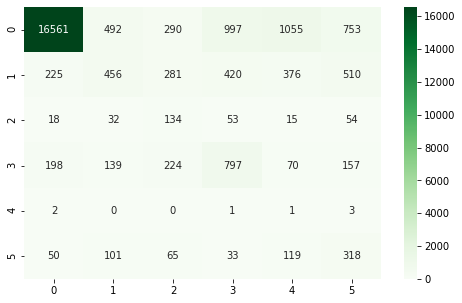

In [60]:
plt.figure(figsize=(8,5))
sns.heatmap(cnf_matrix_sm_MNLR, annot=True, cmap='Greens',fmt='g')

In [74]:
# XGboost for multinomial classification

import xgboost as xgb

In [76]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [98]:
# instantiate XGBoost classifier
xg_reg = xgb.XGBClassifier(objective ='multi:softmax', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [104]:
# fit regressor and predict
xg_reg.fit(X_train_res,y_train_res)
preds = xg_reg.predict(X_test)

In [105]:
# compute root mean square error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1.356628


In [106]:
print("Accuracy:", accuracy_score(y_test, preds))
print("Recall:", recall_score(y_test, preds, average='macro'))
print('Precision:', precision_score(y_test, preds, average='macro'))

Accuracy: 0.78408
Recall: 0.5074077076881514
Precision: 0.35481431183113893


<AxesSubplot:>

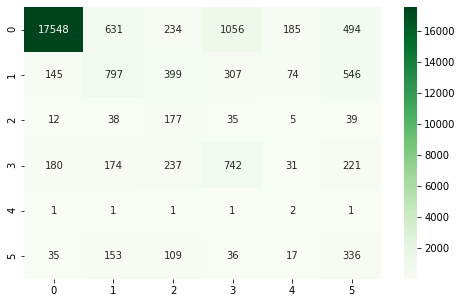

In [107]:
cnf_matrix_xgb = metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(8,5))
sns.heatmap(cnf_matrix_xgb, annot=True, cmap='Greens',fmt='g')

## Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training.

In [64]:
# split out X and y variables
y = cancel['cancelled']
X = cancel.drop(['cancelled','cancellation_code','fl_date'],axis=1)

# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)



In [65]:
import sklearn.linear_model as lm
from sklearn.metrics import roc_auc_score

#instantiate logistic model
LR = lm.LogisticRegression(max_iter=3000,random_state=0, solver='liblinear')

# fit training data
LR.fit(X_train,y_train)

# predict with test data
y_pred_LR = LR.predict_proba(X_test)

# Keep only the positive class
y_pred_LR = [p[1] for p in y_pred_LR]

print('ROC AUC Score:', roc_auc_score(y_test, y_pred_LR))

ROC AUC Score: 0.7523018225657188


In [119]:
# Using SMOTE to balance dataset


print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 1264
Before OverSampling, counts of label '0': 73736 

After OverSampling, the shape of train_X: (147472, 21)
After OverSampling, the shape of train_y: (147472,) 

After OverSampling, counts of label '1': 73736
After OverSampling, counts of label '0': 73736


In [67]:
X_train_res['crs_arr_binned'] = X_train_res['crs_arr_binned'].cat.add_categories('0')
X_train_res['crs_arr_binned'].fillna('0',inplace=True)
X_train_res['crs_drp_binned'] = X_train_res['crs_drp_binned'].cat.add_categories('0')
X_train_res['crs_drp_binned'].fillna('0',inplace=True)
X_train_res['dist_binned'] = X_train_res['dist_binned'].cat.add_categories('0')
X_train_res['dist_binned'].fillna('0',inplace=True)

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': [1,5,7,9]
             }
lr = LogisticRegression(max_iter=3000,random_state=0, solver='liblinear')
clf = GridSearchCV(lr, parameters, cv=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=3000, random_state=0,
                                          solver='liblinear'),
             n_jobs=3, param_grid={'C': [1, 5, 7, 9]})

In [69]:
# check best parameters
clf.best_params_

{'C': 7}

In [70]:
# use best parameter for logistic regression
lr1 = LogisticRegression(C=7, max_iter=3000, solver='liblinear')
lr1.fit(X_train_res, y_train_res.ravel())
y_pred_sm_LR = lr1.predict(X_test)

In [71]:
# create confusion matrix
cnf_matrix_lr = metrics.confusion_matrix(y_test, y_pred_sm_LR)
print(cnf_matrix_lr)

# print accuracy, recall, precision stats
print("Accuracy:", accuracy_score(y_test, y_pred_sm_LR))
print("Recall:", recall_score(y_test, y_pred_sm_LR))
print("Precision:", precision_score(y_test, y_pred_sm_LR))

[[22404  2189]
 [  294   113]]
Accuracy: 0.90068
Recall: 0.27764127764127766
Precision: 0.04908774978279757


<AxesSubplot:>

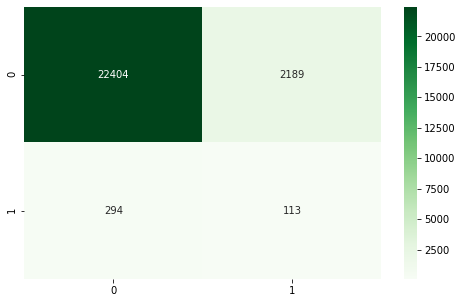

In [72]:
plt.figure(figsize=(8,5))
sns.heatmap(cnf_matrix_lr, annot=True, cmap='Greens',fmt='g')

### Using Random Forests for binary classification

In [108]:
# Use Random Forest Classifier for binary classification

from sklearn.ensemble import RandomForestClassifier

# instantiate the model (using the default parameters)
RF = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)

# fit the model with data
RF.fit(X_train,y_train)

# predict using the fitted data
y_pred_RF = RF.predict(X_test)



In [109]:
# create confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_RF)
cnf_matrix

array([[19941,   207,     0,     0,     0,     0],
       [ 1476,   792,     0,     0,     0,     0],
       [  134,   172,     0,     0,     0,     0],
       [ 1171,   414,     0,     0,     0,     0],
       [    6,     1,     0,     0,     0,     0],
       [  387,   299,     0,     0,     0,     0]])

In [111]:
# confusion matrix evaluation metrics

print("Accuracy:", accuracy_score(y_test, y_pred_RF))
print("Recall:", recall_score(y_test, y_pred_RF,average='macro'))
print("Precision:", precision_score(y_test, y_pred_RF,average='macro'))



Accuracy: 0.82932
Recall: 0.22315539610060156
Precision: 0.21380761972630216


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
X_train

,op_unique_carrier,cloud_cover,precipitation,snow_depth,snow_fall,wind_speed,crs_arr_binned,crs_drp_binned,month,day,...,car_avg_delay,origin_avg_delay,airport_dep_delay_moving_2,airport_dep_delay_moving_5,airport_arr_delay_moving_2,airport_arr_delay_moving_5,carrier_dep_delay_moving_2,carrier_dep_delay_moving_5,carrier_arr_delay_moving_2,carrier_arr_delay_moving_5
2904465,23,0.49,0.00,0.0,0.0,2.7,3,3,3,8,...,10.419887,9.235837,-4.0,-3.20,2.0,-6.8,-4.0,-3.2,-6.0,-11.80
2256716,3,0.39,0.00,0.0,0.0,4.6,6,5,4,9,...,7.780214,8.643950,-4.0,5.00,0.0,0.0,-4.0,-5.0,-13.0,-21.60
7685534,3,0.10,0.00,0.0,0.0,5.4,4,3,3,8,...,7.780214,9.235837,-1.5,-0.40,-2.0,-6.4,-1.5,-0.4,1.0,-5.80
2419087,3,0.05,0.00,0.0,0.0,6.4,4,3,4,16,...,7.780214,13.155478,-5.5,-2.20,-12.5,-9.2,-5.5,-2.2,-12.5,-9.20
6879472,21,0.43,0.00,0.0,0.0,3.8,4,4,6,3,...,7.998840,13.778252,-0.5,-2.40,-7.5,-7.0,-0.5,-2.4,-16.0,-13.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8199489,1,0.01,0.00,0.0,0.0,3.5,6,5,3,31,...,10.559512,9.235837,14.0,2.20,18.0,18.0,14.0,2.2,13.0,1.00
4881828,1,0.02,0.07,0.0,0.0,1.8,5,5,8,5,...,10.559512,9.235837,1.5,-2.00,0.0,0.0,1.5,-2.0,-6.0,-2.75
7971285,8,0.70,0.22,2.8,2.0,3.4,5,4,3,21,...,11.339147,11.729100,-2.0,10.50,6.0,15.2,-2.0,10.5,6.0,20.75
4727234,5,0.78,0.23,0.0,0.0,6.7,6,5,1,29,...,11.513411,8.600237,14.0,12.75,17.5,11.2,14.0,9.2,14.0,10.80


In [124]:
RF

RandomForestClassifier(max_depth=3, random_state=0)

In [126]:
feature_imp = pd.Series(RF.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp

ValueError: Length of passed values is 28, index implies 21.

In [113]:
# try again after eliminating worst features
cancel_new = cancel.drop(['dest_airport_id','diverted',
                         'flights','year','dist_binned',
                         'dest_avg_delay','origin_airport_id',
                         'day_of_week'], axis=1)

In [114]:
# split out X and y variables
y = cancel_new['cancelled']
X = cancel_new.drop(['cancelled','cancellation_code','fl_date'],axis=1)

# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

# istantiate, fit and predict model
RF1 = RandomForestClassifier(n_estimators=100, max_depth=60, random_state=0, min_samples_leaf=1,min_samples_split=2)
RF1.fit(X_train,y_train)
y_pred_RF1 = RF1.predict(X_test)

cnf_matrix1 = metrics.confusion_matrix(y_test, y_pred_RF1)
print(cnf_matrix1)

print("Accuracy:", accuracy_score(y_test, y_pred_RF1))
print("Recall:", recall_score(y_test, y_pred_RF1))
print("Precision:", precision_score(y_test, y_pred_RF1))

[[24592     1]
 [  348    59]]
Accuracy: 0.98604
Recall: 0.14496314496314497
Precision: 0.9833333333333333


In [127]:
feature_imp = pd.Series(RF1.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp

carrier_arr_delay_moving_2    0.083656
airport_arr_delay_moving_2    0.082749
airport_arr_delay_moving_5    0.075703
carrier_dep_delay_moving_2    0.073038
airport_dep_delay_moving_2    0.070797
carrier_arr_delay_moving_5    0.069124
airport_dep_delay_moving_5    0.062558
carrier_dep_delay_moving_5    0.061964
wind_speed                    0.054860
origin_avg_delay              0.046816
cloud_cover                   0.044582
precipitation                 0.044152
day                           0.039691
month                         0.027062
passengers_y                  0.026699
op_unique_carrier             0.025443
car_avg_delay                 0.024901
crs_drp_binned                0.023204
crs_arr_binned                0.022247
snow_fall                     0.020789
snow_depth                    0.019967
dtype: float64

In [21]:
# grid search to improve parameters

parameters_RF = {
    'n_estimators': [50,100],
    'max_depth':[10,30],
    'min_samples_leaf': [1, 4],
    'min_samples_split': [2, 10],
             }
RF = RandomForestClassifier()
RF_clf = GridSearchCV(estimator=RF, param_grid=parameters_RF, cv=5, n_jobs=-1)
RF_clf.fit(X_train, y_train)

RF_clf.best_params_


{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [22]:
# use SMOTE then do random forests

# split out X and y variables
y = cancel_new['cancelled']
X = cancel_new.drop(['cancelled','cancellation_code','fl_date'],axis=1)

# split X and y into training and testing sets and smote it
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

# fix nan values that somehow form after smoting
X_train_res['crs_arr_binned'] = X_train_res['crs_arr_binned'].cat.add_categories('0')
X_train_res['crs_arr_binned'].fillna('0',inplace=True)
X_train_res['crs_drp_binned'] = X_train_res['crs_drp_binned'].cat.add_categories('0')
X_train_res['crs_drp_binned'].fillna('0',inplace=True)


In [23]:
# istantiate, fit and predict model
RF2 = RandomForestClassifier(n_estimators=100, max_depth=60, random_state=0, min_samples_leaf=1,min_samples_split=2)
RF2.fit(X_train_res,y_train_res.ravel())
y_pred_RF2 = RF2.predict(X_test)

cnf_matrix2 = metrics.confusion_matrix(y_test, y_pred_RF2)
print(cnf_matrix2)

print("Accuracy:", accuracy_score(y_test, y_pred_RF2))
print("Recall:", recall_score(y_test, y_pred_RF2))
print("Precision:", precision_score(y_test, y_pred_RF2))

[[24583    10]
 [  363    44]]
Accuracy: 0.98508
Recall: 0.10810810810810811
Precision: 0.8148148148148148


<AxesSubplot:>

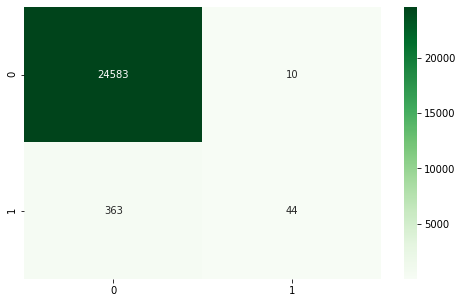

In [73]:
plt.figure(figsize=(8,5))
sns.heatmap(cnf_matrix2, annot=True, cmap='Greens',fmt='g')

In [128]:
feature_imp = pd.Series(RF2.feature_importances_, index=X_train_res.columns).sort_values(ascending=False)
feature_imp

crs_drp_binned                0.349191
crs_arr_binned                0.305476
precipitation                 0.063743
snow_depth                    0.025468
snow_fall                     0.022324
cloud_cover                   0.021162
airport_arr_delay_moving_5    0.021154
airport_arr_delay_moving_2    0.018810
month                         0.018783
carrier_arr_delay_moving_5    0.017940
carrier_arr_delay_moving_2    0.016180
origin_avg_delay              0.015993
carrier_dep_delay_moving_2    0.015372
airport_dep_delay_moving_2    0.015078
airport_dep_delay_moving_5    0.013666
carrier_dep_delay_moving_5    0.012246
passengers_y                  0.011018
car_avg_delay                 0.010374
wind_speed                    0.009726
day                           0.008466
op_unique_carrier             0.007829
dtype: float64

## Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: let's use the weather API we know about to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at a last of couple of delays and compute these statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

## Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [24]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import silhouette_score

In [26]:
d_sample = delayed_df.sample(n=100000)
c_sample = cancel_df.sample(n=100000)

d_sample = d_sample.drop(['fl_date'], axis=1)
c_sample = c_sample.drop(['fl_date'], axis=1)

pca_del = PCA().fit_transform(d_sample)
pca_canc = PCA().fit_transform(c_sample)

delay_evr = PCA().fit(d_sample).explained_variance_ratio_
cancel_evr = PCA().fit(c_sample).explained_variance_ratio_

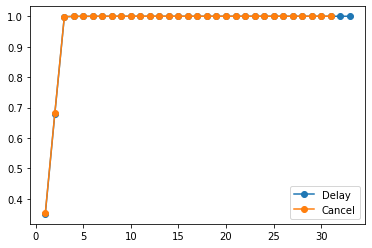

In [27]:
# create cumulative explained variance ratio plot to evaluate appropriate n_components

plt.figure(figsize=(6,4))
plt.plot(range(1,pca_del.shape[1]+1),delay_evr.cumsum(), marker = 'o', label='Delay')
plt.plot(range(1,pca_canc.shape[1]+1),cancel_evr.cumsum(), marker = 'o', label ='Cancel')
plt.legend()
plt.show()

### Both dataframes would be good candidates to reduce data to first two principal components

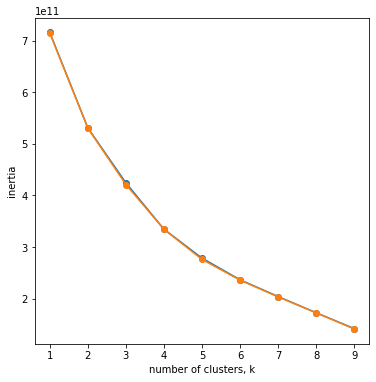

In [31]:
# create elbow plot to evaluate appropriate number of clusters

ks_del = range(1, 10)
inertias_del = []
for k in ks_del:
    model = KMeans(n_clusters=k)
    model.fit(d_sample)
    inertias_del.append(model.inertia_)

ks_canc = range(1, 10)
inertias_canc = []
for k in ks_canc:
    model = KMeans(n_clusters=k)
    model.fit(c_sample)
    inertias_canc.append(model.inertia_)

plt.figure(figsize=(6,6))    
    
plt.plot(ks_del, inertias_del, '-o', label='Delayed DF')
plt.plot(ks_canc, inertias_canc, '-o', label='Cancelled DF')

plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.show()

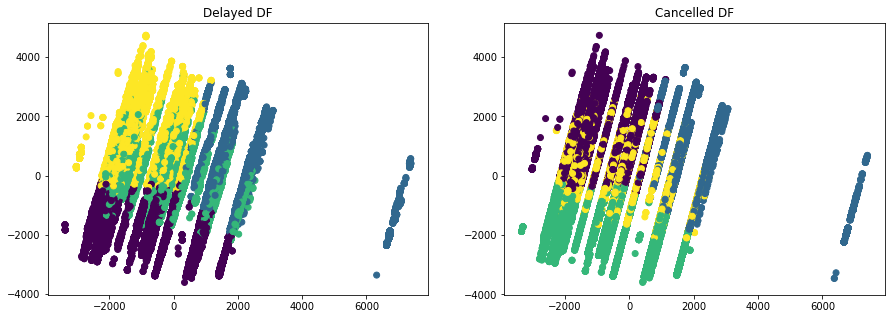

In [32]:
# does kmeans clustering do something??

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=123)

y_del = kmeans.fit_predict(d_sample)
y_canc = kmeans.fit_predict(c_sample)

# plot kmeans clusters
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
   
ax1.scatter(pca_del[:, 0], pca_del[:, 1], c=y_del)
ax1.set_title('Delayed DF')
ax2.scatter(pca_canc[:, 0], pca_canc[:, 1], c=y_canc)
ax2.set_title('Cancelled DF')

plt.show()

## Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

## Evaluation

You have data from 2018 and 2019 to develop model that is as good as possible. Use different evaluation metrics for each problem and compare the performance of different models.

Final evaluation will be done on data from January 2020 to compare the results from different teams on out of sample data.